In [34]:
from qutip import *
import numpy as np
from numpy.polynomial.hermite import hermval
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import math
from matplotlib import rc

scale = 1.2
sizeOfFont = scale*15
fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
     'size' : sizeOfFont}
rc('text', usetex=True)
rc('font',**fontProperties)
rc('text.latex', preamble=r'\usepackage{sansmathfonts}')

# Ideal binomial codewords
def bincode(N, K,mu):
    """Ideal binomial codewords. mu = 0 is the plus logical state."""
    return sum(np.sqrt(math.comb(K, i)/2**K) *((-1)**(i*mu)) * basis(K*N, i*N) for i in range(0,K,1))

# Fix binomial code parameters
Kval = 3
Nval = 4  
muval = 0 

# Input
psi1 = bincode(Nval, Kval, muval)
psi2 = basis(Nval*Kval, 0)

# Destruction operators in the tensor product space of the input
N = Kval*Nval # define max dimension in the simulation
a1 = composite(destroy(N),identity(N))
a2 = composite(identity(N),destroy(N))


## Beamsplitter Matrix
# quantum Stokes, eqn 4.6:
Lt = 1/2*(a1.dag()*a1 + a2.dag()*a2)
Lx = 1/2*(a1.dag()*a2 + a2.dag()*a1)
Ly = 1j/2*(a2.dag()*a1 - a1.dag()*a2)
Lz = 1/2*(a1.dag()*a1 - a2.dag()*a2)
def Bmatrix(Φ,Θ,Ψ,Λ):
    """This is the classical matrix given in 4.4, mainly to confirm parameter choice"""
    a = np.exp(1j*Λ/2)
    b = np.array([[np.exp(1j*Ψ/2),0],[0,np.exp(-1j*Ψ/2)]])
    c = np.array([[np.cos(Θ/2),np.sin(Θ/2)],[-np.sin(Θ/2),np.cos(Θ/2)]])
    d = np.array([[np.exp(1j*Φ/2),0],[0,np.exp(-1j*Φ/2)]])
    return a * b @ c @ d

# Beamsplitter Unitary Operator
def B(Φ,Θ,Ψ,Λ):
    """Create the B operator given in 4.12"""
    B = (-1j*Φ*Lz).expm() * (-1j*Θ*Ly).expm() * (-1j*Ψ*Lx).expm() * (-1j*Λ*Lt).expm()
    return B


# pure vacuum loss and beamsplitter
def pureLossChannel(Loss,psi_keep,psi_loose):
    """Density operator after pure vacuum loss channel"""
    # Create a beamsplitter for the simulation
    Θ = 2*np.arccos(np.sqrt(1-Loss))
    bs = B(0,Θ,0,0) # Compute the beamsplitter unitary
    return (bs.dag() * composite(psi_keep,psi_loose)).ptrace(0)


# k-Photon Subtraction
def kPS(eta,k,T,psi_interest,psi_project):
    """Density operator after "eta efficient" k-Photon Subtraction at a beamsplitter with transmittance T"""
    # Create a beamsplitter for the simulation
    Θ = 2*np.arccos(np.sqrt(T))
    bs = B(0,Θ,0,0) # Compute the beamsplitter unitary
    dim_interest = psi_interest.shape[0]
    dim_project  = psi_project.shape[0]
    state = composite(psi_interest,psi_project)
    # another beamsplitter to simulate loss
    lossbs = composite(identity(dim_interest), bs.dag())
     
     """
     NEED TO MODIFY BEAMSPLITTER SO THAT IT TAKES MODE NUMBERS AS INPUT AND TO MIX AND LEAVE OTHERS UNAFFECTED
     
     """
     
     pureLossChannel(1-eta, bs.dag() * , fock(dim_project, 0))
    Pi = composite(identity(dim_interest), fock_dm(dim_project, k))
    povm=[Pi, composite(identity(dim_interest), identity(dim_project)) - Pi]
    return (qutip.measurement.measurement_statistics_povm(state, povm )[0][0]).ptrace(0)

In [48]:
bs = B(0,2*np.arccos(np.sqrt(0.75)),0,0)
psibs1 = composite(bs.dag() * composite(psi1,psi2),psi2)
psibs1

Quantum object: dims = [[12, 12, 12], [1, 1, 1]], shape = (1728, 1), type = ket
Qobj data =
[[0.35355339]
 [0.        ]
 [0.        ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]

In [50]:
bs2op = tensor(identity(psi1.shape[0]),bs.dag())
bs2op*psibs1

Quantum object: dims = [[12, 12, 12], [1, 1, 1]], shape = (1728, 1), type = ket
Qobj data =
[[0.35355339]
 [0.        ]
 [0.        ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]

In [29]:
pureLossChannel(0,  B(0,2*np.arccos(np.sqrt(0.75)),0,0).dag() * composite(psi1,psi2), psi2)

TypeError: Incompatible Qobj shapes

In [25]:
def psi_n(n:int,x):
    """Evalutes the <x|n> wavefunction at x"""
    return (1/(np.sqrt(2**n)*math.factorial(n)))*(np.pi)**(1/4)*np.exp(-(x**2)/2)*hermval(x,[n])

def psi_x(N:int, x):
    """State |x> constructed in the Fock basis expansion
        N is the total number of Fock basis used
    """
    return sum([psi_n(n,x)*fock(N,n) for n in range(N)])

def Pi_x(N:int, x):
    """von Neumann projector Pi_x :=  |x> <x| """
    return ket2dm(psi_x(N, x))

def homodyne(N:int, center, Delta, points:int):
    """Kraus operator that projects the state onto the sum of |x_i><x_i| projectors in a Delta range around center"""
    return sum([Pi_x(N, x) for x in np.linspace(center-Delta/2,center+Delta/2, points)])

homodyne(20,0,10,100)

Quantum object: dims = [[20], [20]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.55508836e+01 1.09961353e+01 3.88772091e+00
  9.16344606e-01 1.61988371e-01 2.29086151e-02 2.69980618e-03
  2.72721606e-04 2.41054094e-05 1.89389785e-06 1.33916556e-07
  8.60561337e-09 5.02161598e-10 1.88473067e-11 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.09961353e+01 7.77544182e+00 2.74903382e+00
  6.47953485e-01 1.14543076e-01 1.61988371e-02 1.90905126e-03
  1.92843297e-04 1.70450985e-05 1.33918639e-06 9.46918015e-08
  6.08356892e-09 3.53285023e-10 6.47771717e-12 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00

In [28]:
# Results
T = 0.75
outkPS  = kPS(0.75,0,T, psi1,psi2)
outLoss = pureLossChannel(1-T,psi1,psi2)

#Plotting
limi = 3.54
rang = 100 
xvec = np.linspace(-limi, limi, rang)

W1  = wigner(outkPS, xvec, xvec)
W2 = wigner(outLoss, xvec, xvec)

nrm1 = mpl.colors.Normalize(-W1.max(), W1.max())
nrm2 = mpl.colors.Normalize(-W2.max(), W2.max())

# Increasing the resolution of the plot
plt.figure(dpi=100)

fig, axes = plt.subplots(1, 2, figsize=(scale*5*2,scale*4),sharey = True)

plt1 = axes[0].contourf(xvec, xvec, W1, 100, cmap=cm.RdBu, norm=nrm1)
plt2 = axes[1].contourf(xvec, xvec, W2, 100, cmap=cm.RdBu, norm=nrm2)

axes[0].set(title = f"Zero Photon Subtraction", xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[1].set(title = f"Pure Vacuum Loss",        xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )

cb1= fig.colorbar(plt1, ax=axes[0])
cb1.ax.tick_params(labelsize = scale*12)

cb2= fig.colorbar(plt2, ax=axes[1])
cb2.ax.tick_params(labelsize = scale*12)

fig.tight_layout()

plt.show()

TypeError: Incompatible Qobj shapes

<Figure size 640x480 with 0 Axes>

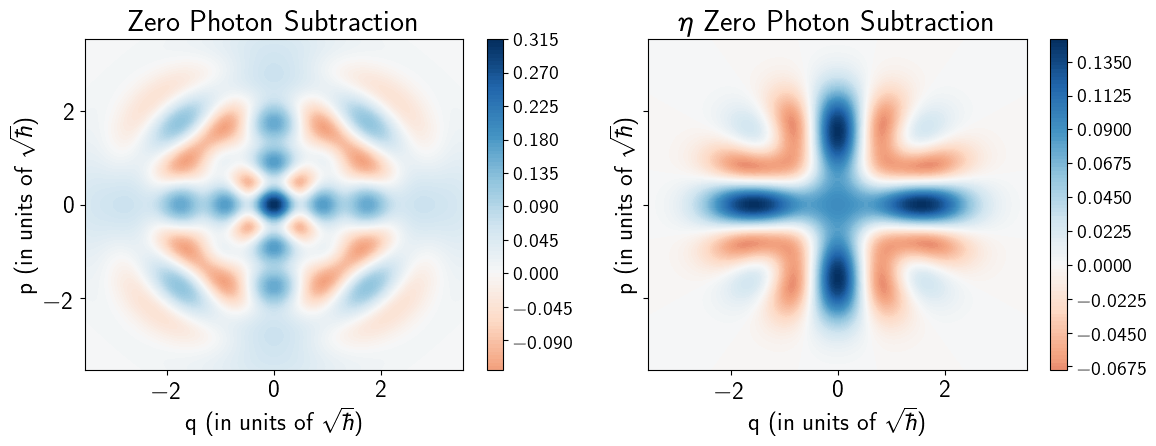

In [18]:
# Results
T = 0.85 # transmittance of the beamsplitter used for ZPS
eta = 0.001 # efficiency of ZPS
outkPS  = kPS(0.9,0,T,psi1,psi2)
outkPSeta  = pureLossChannel(1-eta,outkPS,fock_dm(outkPS.shape[0],0))

#Plotting
limi = 3.54
rang = 100 
xvec = np.linspace(-limi, limi, rang)

W1  = wigner(outkPS, xvec, xvec)
W2 = wigner(outkPSeta, xvec, xvec)

nrm1 = mpl.colors.Normalize(-W1.max(), W1.max())
nrm2 = mpl.colors.Normalize(-W2.max(), W2.max())

# Increasing the resolution of the plot
plt.figure(dpi=100)

fig, axes = plt.subplots(1, 2, figsize=(scale*5*2,scale*4),sharey = True)

plt1 = axes[0].contourf(xvec, xvec, W1, 100, cmap=cm.RdBu, norm=nrm1)
plt2 = axes[1].contourf(xvec, xvec, W2, 100, cmap=cm.RdBu, norm=nrm2)

axes[0].set(title = f"Zero Photon Subtraction", xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[1].set(title = f"$\eta$ Zero Photon Subtraction",        xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )

cb1= fig.colorbar(plt1, ax=axes[0])
cb1.ax.tick_params(labelsize = scale*12)

cb2= fig.colorbar(plt2, ax=axes[1])
cb2.ax.tick_params(labelsize = scale*12)

fig.tight_layout()

plt.show()